# Text Classification Using Word Embeddings In IMDB Reviews Dataset

In [1]:
import tensorflow as tf
print(tf.__version__)

tf.enable_eager_execution() # For tensorflow 1.14. If you using tensorflow 2 you don't need to enable eager executions.

1.14.0


## Getting the dataset

```shell
 pip install -q tensorflow-datasets
```

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Data preprocessing

In [3]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Extracting labels and sentences
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
# Label 1 indicates positive review and 0 a negative one.
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Tokenizing the sentences

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>" # out of vocabulary
# If the sentence size more than 120 it will truncated. If it's less than 120 it will padded.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# training tokens
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# testing tokens
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [5]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

b as a <OOV> fan of dickens i have <OOV> been disappointed by adaptations of his novels br br although his works presented an extremely accurate re telling of human life at every level in victorian britain throughout them all was a <OOV> thread of humour that could be both playful or sarcastic as the narrative <OOV> in a way he was a literary <OOV> and <OOV> he could be serious and hilarious in the same sentence he <OOV> pride <OOV> arrogance celebrated modesty and <OOV> with loneliness and poverty it may be a clich xc3 xa9 but he was a people's writer br br and it is the comedy that is so often missing from his interpretations at the
b"As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he wa

## Defining the neural network

In [6]:
# Architecture of the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # For text sentiment analysis
    # tf.keras.layers.GlobalAveragePooling1D() # It's little bit faster than Flatten and less accurate
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Configuration for model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [7]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
25000/25000 [==============================] - 4s 155us/sample - loss: 0.5747 - acc: 0.7127 - val_loss: 0.4543 - val_acc: 0.8420
Epoch 2/10
25000/25000 [==============================] - 3s 115us/sample - loss: 0.3475 - acc: 0.8925 - val_loss: 0.4111 - val_acc: 0.8356
Epoch 3/10
25000/25000 [==============================] - 3s 114us/sample - loss: 0.1925 - acc: 0.9570 - val_loss: 0.4484 - val_acc: 0.8294
Epoch 4/10
25000/25000 [==============================] - 3s 124us/sample - loss: 0.1137 - acc: 0.9815 - val_loss: 0.5245 - val_acc: 0.8242
Epoch 5/10
25000/25000 [==============================] - 3s 110us/sample - loss: 0.0822 - acc: 0.9864 - val_loss: 0.5510 - val_acc: 0.8253
Epoch 6/10
25000/25000 [==============================] - 3s 107us/sample - loss: 0.0663 - acc: 0.9884 - val_loss: 0.5852 - val_acc: 0.8255
Epoch 7/10
25000/25000 [==============================] - 3s 107us/sample - loss: 0.0590 - acc: 0.9889 - val_loss: 0.6020 - val_acc: 0.8283
Epoch 8/10
25000/250

## Plotting the results

- We can easily see that overfitting happens in the training.

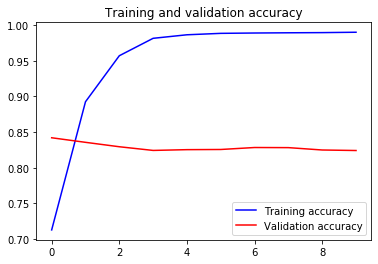

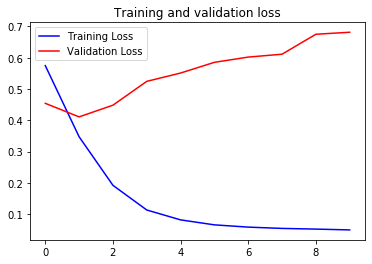

In [12]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Saving vectors and metadata auto files

- After saving the vectors and metadata auto files, we can visualizes word vectors in Tensorflow Embedding Projector.

https://projector.tensorflow.org/

In [10]:
# Results of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [11]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    # reverse word index reverses the keys to values
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()